In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
import lightgbm as lgb
from xgboost import XGBClassifier
from tqdm import tqdm

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jabezianchrispenalver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jabezianchrispenalver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jabezianchrispenalver/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jabezianchrispenalver/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv("Suicide_Detection.csv")

In [4]:
# Display the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [5]:
# Select only 232,074 rows
df = df.sample(n=232074, random_state=42)

Class distribution saved as plots/class_distribution.png


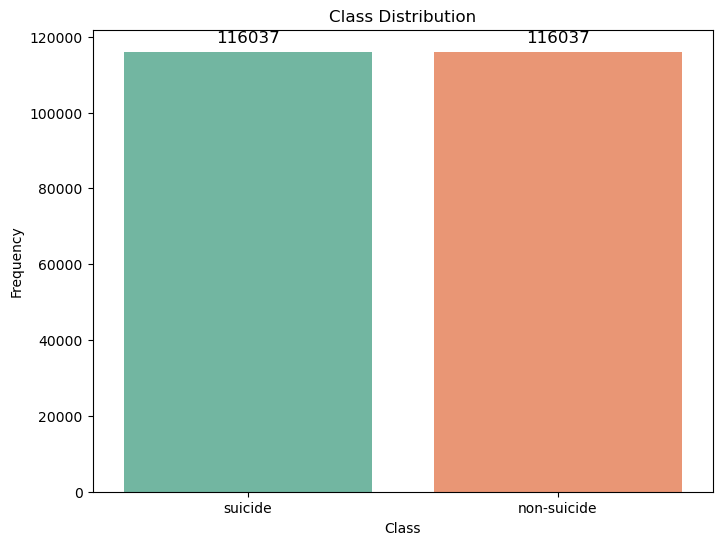

In [6]:
# Visualize the class distribution with data points inside bars and save the plot
def save_class_distribution(df, output_dir="plots"):
    """Save class distribution plot as an image file."""
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x='class', hue='class', palette='Set2', legend=False)
    
    # Add counts on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, color='black')
    
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    # Create output directory for saving the plot, if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save the plot as an image file (e.g., PNG)
    filename = f"{output_dir}/class_distribution.png"
    plt.savefig(filename)
    print(f"Class distribution saved as {filename}")

    plt.show()

# Save the class distribution plot
save_class_distribution(df)

In [7]:
# Initialize stop words, lemmatizer, and punctuation removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text: lowercasing, tokenization, punctuation and stopword removal, and lemmatization."""
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

In [8]:
# Apply preprocessing to the text column
df['text'] = df['text'].apply(preprocess_text)

In [9]:
# Map categorical labels to numeric values
label_mapping = {'non-suicide': 0, 'suicide': 1}
df['class'] = df['class'].map(label_mapping)

# Split the data into features (X) and target (y)
X = df['text']
y = df['class']

In [10]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

In [11]:
# Initialize classifiers
classifiers = {
    # "Naive Bayes": MultinomialNB(),
    # "Logistic Regression": LogisticRegression(max_iter=1000),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    # "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier(),
    # "LightGBM": lgb.LGBMClassifier(),
    # "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Support Vector Machine": SVC(kernel='linear'),
}

In [12]:
def evaluate_classifier(clf, X_vect, y):
    """Evaluate classifier using cross-validation and return evaluation metrics and predictions."""
    y_pred = cross_val_predict(clf, X_vect, y, cv=10)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    accuracy = accuracy_score(y, y_pred)
    return precision, recall, f1, accuracy, y_pred

In [13]:
def plot_confusion_matrix(y_true, y_pred, clf_name, precision, recall, f1, accuracy):
    """Plot confusion matrix for given classifier results and include evaluation metrics in the plot."""
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {clf_name}')
    
    # Add metrics as text in the plot
    metrics_text = (f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}")
    
    # Place metrics text in the bottom right corner of the plot
    plt.gcf().text(0.95, 0.5, metrics_text, ha='right', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Create a directory for saving confusion matrices, if it doesn't exist
    output_dir = "confusion_matrices"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save the plot as an image file (e.g., PNG)
    filename = f"{output_dir}/confusion_matrix_{clf_name}.png"
    plt.savefig(filename, bbox_inches='tight')
    print(f"Confusion matrix saved as {filename}")

    plt.show()

Training classifiers:   0%|                               | 0/1 [00:00<?, ?it/s]

Classifier: Support Vector Machine
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Accuracy: 0.94
Confusion matrix saved as confusion_matrices/confusion_matrix_Support Vector Machine.png


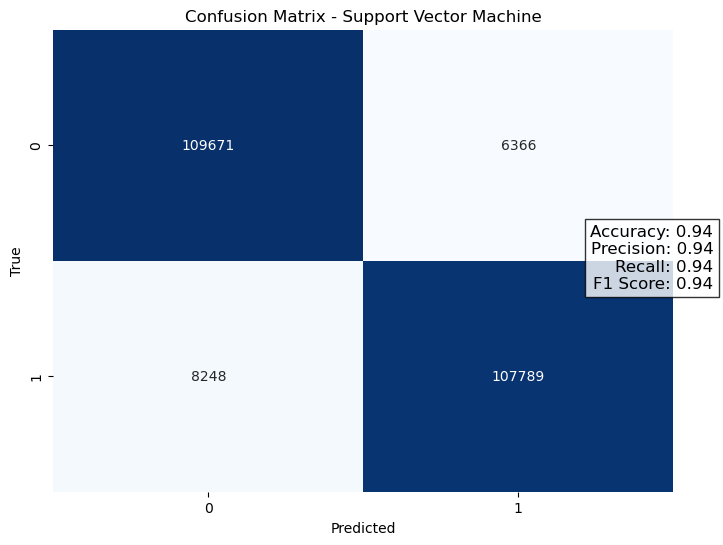

Training classifiers: 100%|████████████████| 1/1 [51:12:44<00:00, 184364.75s/it]


In [14]:
# Track the classifier with the highest accuracy
best_clf_name = None
best_clf_accuracy = 0
best_clf = None

# Perform evaluation for each classifier with a loading bar
for clf_name, clf in tqdm(classifiers.items(), desc="Training classifiers"):
    precision, recall, f1, accuracy, y_pred = evaluate_classifier(clf, X_vect, y)
    
    # Display evaluation metrics
    print(f"Classifier: {clf_name}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    
    # Plot confusion matrix with metrics
    plot_confusion_matrix(y, y_pred, clf_name, precision, recall, f1, accuracy)
    
    # Update best classifier
    if accuracy > best_clf_accuracy:
        best_clf_accuracy = accuracy
        best_clf_name = clf_name
        best_clf = clf

In [15]:
# Save the best classifier to a pickle file
with open('best_classifier.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

print(f"The best classifier is: {best_clf_name}, with accuracy: {best_clf_accuracy:.2f}")

The best classifier is: Support Vector Machine, with accuracy: 0.94
